In [10]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [11]:
tot_data_train_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_c.parquet')
tot_data_train_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_p.parquet')


firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')


columns_to_drop = ['trading_days_till_exp'] + list(firm_data.columns[2:])

tot_data_train_c = tot_data_train_c.drop(columns=columns_to_drop, errors='ignore')
tot_data_train_p = tot_data_train_p.drop(columns=columns_to_drop, errors='ignore')


Evaluating features for Call options...
Training RandomForest model with 100 trees...
Performing permutation importance...

Feature importances for Call options:
                         Feature  Importance  Importance_std
0                    prev_day_iv    1.303063        0.006151
1                              T    0.195049        0.003449
2                      vol_stock    0.074643        0.001135
3                   prev2_day_iv    0.060377        0.000570
4                    hi-lo_stock    0.043907        0.000548
5                        1Y_bond    0.039736        0.000540
6                      moneyness    0.021638        0.000371
7                   spread_stock    0.020377        0.000293
8                     spread_vix    0.018834        0.000255
9     5_day_rolling_return_stock    0.016175        0.000291
10                    PRC_actual    0.011438        0.000171
11                    gold_price    0.010939        0.000141
12                     CLOSE_vix    0.010354 

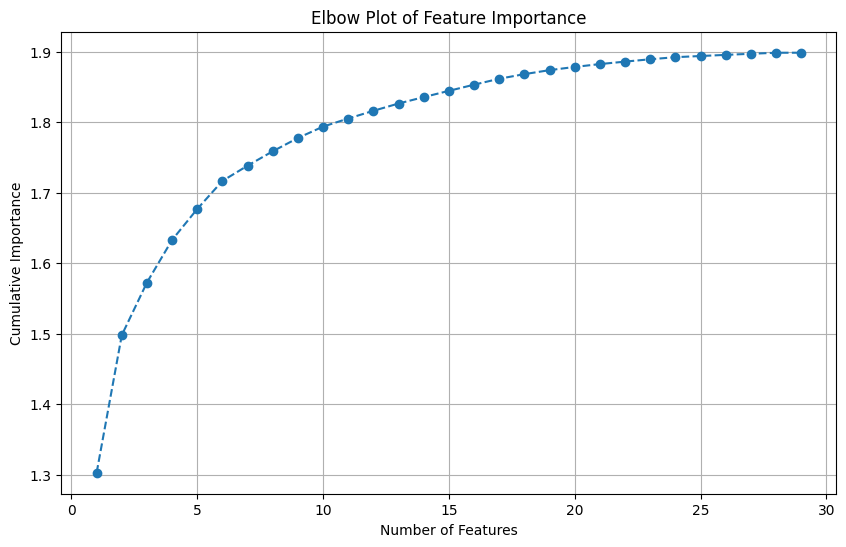


Selected 1 features based on an 85.0% importance threshold.

Selected top features for Call options:
['prev_day_iv']

Evaluating features for Put options...
Training RandomForest model with 100 trees...
Performing permutation importance...

Feature importances for Put options:
                         Feature  Importance  Importance_std
0                    prev_day_iv    1.393239        0.005852
1                              T    0.211333        0.001931
2                      vol_stock    0.066215        0.001117
3                   prev2_day_iv    0.064914        0.000406
4                    hi-lo_stock    0.027359        0.000517
5     5_day_rolling_return_stock    0.018760        0.000223
6                      moneyness    0.018084        0.000200
7                     PRC_actual    0.013057        0.000222
8              cumulative_return    0.008663        0.000233
9                     spread_vix    0.008367        0.000106
10                    gold_price    0.008297      

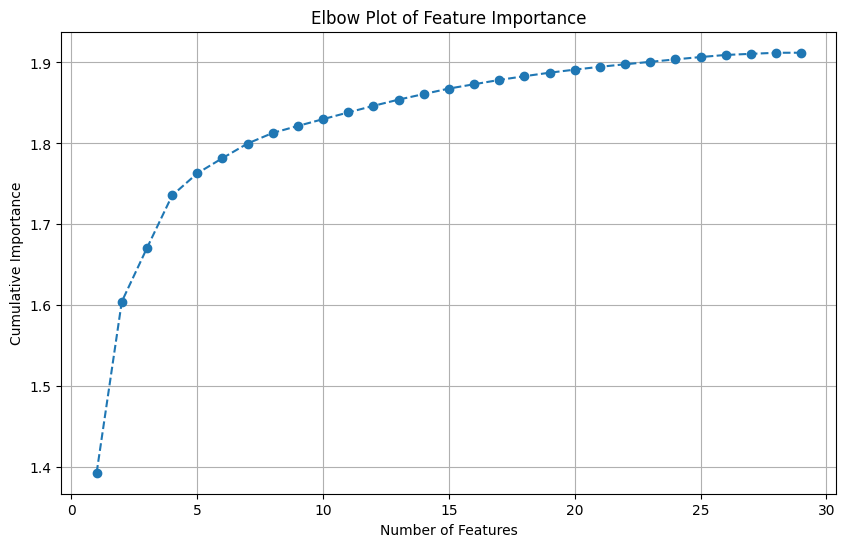


Selected 1 features based on an 85.0% importance threshold.

Selected top features for Put options:
['prev_day_iv']


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def feature_permutation_importance(train_data, n_estimators=100, random_state=42, verbose=True):
    """
    Perform permutation importance on the training data to identify the top features.
    
    Parameters:
    - train_data (pd.DataFrame): The training dataset.
    - n_estimators (int): Number of estimators (trees) for the RandomForestRegressor.
    - random_state (int): Seed for reproducibility.
    - verbose (bool): If True, prints progress information.
    
    Returns:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Prepare the train data
    X_train = train_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Drop unwanted columns
    y_train = train_data['impl_volatility']  # Target variable (implied volatility)

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train a RandomForestRegressor model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    
    if verbose:
        print(f"Training RandomForest model with {n_estimators} trees...")

    rf_model.fit(X_train_scaled, y_train)

    if verbose:
        print("Performing permutation importance...")

    # Perform permutation importance on the training data
    perm_importance = permutation_importance(rf_model, X_train_scaled, y_train, n_repeats=10, random_state=random_state, scoring='r2')

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean,
        'Importance_std': perm_importance.importances_std
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return feature_importances


def plot_elbow_curve(feature_importances):
    """
    Plot an elbow curve to determine how many features to select based on permutation importance.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Cumulative importance to capture the "elbow"
    cumulative_importance = np.cumsum(feature_importances['Importance'])

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--')
    plt.title('Elbow Plot of Feature Importance')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.show()


def select_top_features(feature_importances, threshold=0.85):
    """
    Select top features based on a cumulative importance threshold.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    - threshold (float): Cumulative importance threshold (e.g., 0.85 for 85%).
    
    Returns:
    - selected_features (list): A list of top features to use in the model.
    """
    cumulative_importance = np.cumsum(feature_importances['Importance'])
    
    # Find how many features explain the threshold (e.g., 85%) of importance
    num_features = np.argmax(cumulative_importance >= threshold) + 1
    
    selected_features = feature_importances['Feature'].iloc[:num_features].tolist()
    print(f"\nSelected {num_features} features based on an {threshold*100}% importance threshold.")
    
    return selected_features


# Example usage for tot_data_train_c
print("Evaluating features for Call options...")
feature_importances_call = feature_permutation_importance(tot_data_train_c, verbose=True)

# Display top features and their importance
print("\nFeature importances for Call options:")
print(feature_importances_call)

# Plot the elbow curve to decide on the number of features
plot_elbow_curve(feature_importances_call)

# Select top features (e.g., 85% cumulative importance)
selected_features_call = select_top_features(feature_importances_call, threshold=0.85)

print("\nSelected top features for Call options:")
print(selected_features_call)

# Example usage for tot_data_train_p
print("\nEvaluating features for Put options...")
feature_importances_put = feature_permutation_importance(tot_data_train_p, verbose=True)

# Display top features and their importance
print("\nFeature importances for Put options:")
print(feature_importances_put)

# Plot the elbow curve to decide on the number of features
plot_elbow_curve(feature_importances_put)

# Select top features (e.g., 85% cumulative importance)
selected_features_put = select_top_features(feature_importances_put, threshold=0.85)

print("\nSelected top features for Put options:")
print(selected_features_put)


Evaluating features for Call options...
Training RandomForest model with 100 trees...
Performing permutation importance...

Feature importances for Call options:
                   Feature  Importance  Importance_std
0              prev_day_iv    1.172559    5.026301e-03
1                  idiovol    0.058042    8.324372e-04
2                        T    0.047073    1.031986e-03
3    trading_days_till_exp    0.044550    9.253842e-04
4             prev2_day_iv    0.036632    5.130940e-04
..                     ...         ...             ...
117                     dy    0.000010    1.950613e-07
118             securedind    0.000005    2.400097e-07
119                   sic2    0.000004    4.783520e-07
120                     rd    0.000001    9.117841e-08
121                convind    0.000001    2.172418e-07

[122 rows x 3 columns]


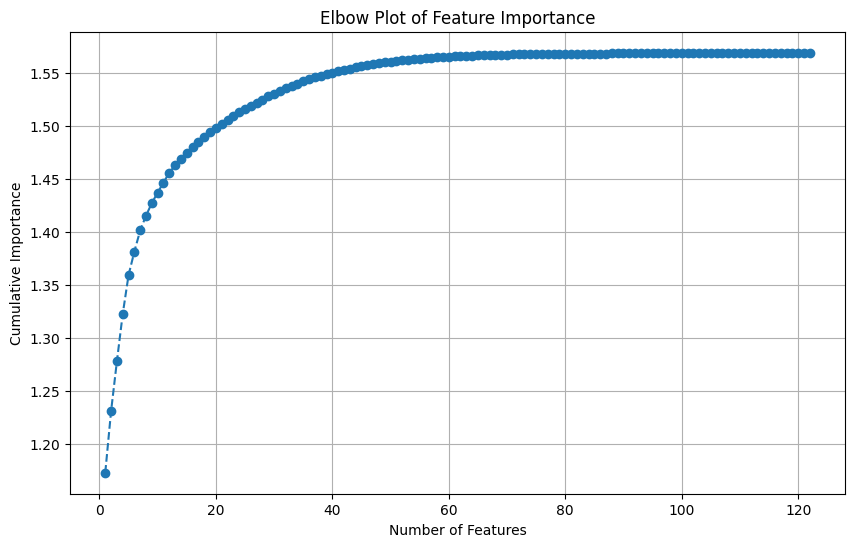


Selected 1 features based on an 85.0% importance threshold.

Selected top features for Call options:
['prev_day_iv']

Evaluating features for Put options...
Training RandomForest model with 100 trees...
Performing permutation importance...

Feature importances for Put options:
                   Feature  Importance  Importance_std
0              prev_day_iv    1.298883    6.623502e-03
1                        T    0.063160    9.296492e-04
2    trading_days_till_exp    0.042703    4.014707e-04
3             prev2_day_iv    0.039644    2.209615e-04
4                  idiovol    0.038580    7.264841e-04
..                     ...         ...             ...
117                     dy    0.000010    5.916638e-07
118             securedind    0.000010    6.587069e-07
119                   sic2    0.000008    3.921294e-07
120                convind    0.000003    2.718937e-07
121                     rd    0.000001    8.694506e-08

[122 rows x 3 columns]


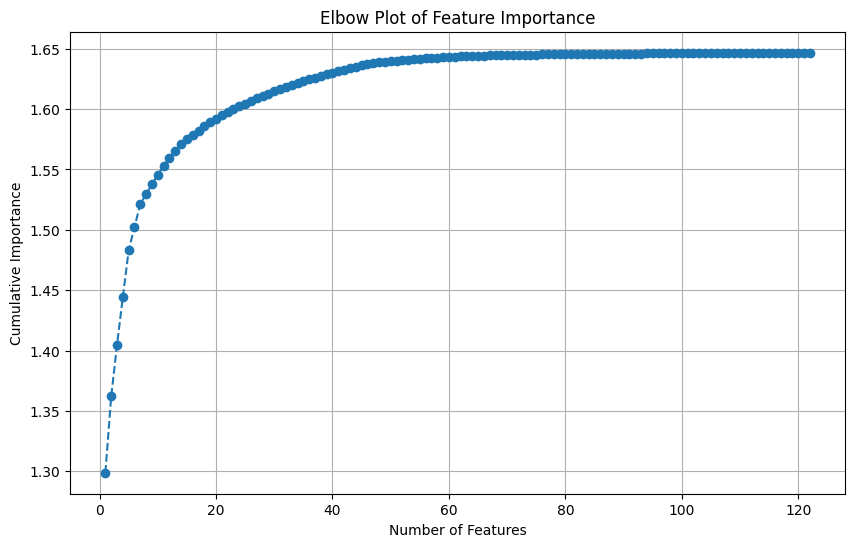


Selected 1 features based on an 85.0% importance threshold.

Selected top features for Put options:
['prev_day_iv']


In [14]:
tot_data_train_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_c.parquet')
tot_data_train_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/updated_standardization/data_set_train_val_tech_scaled_p.parquet')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def feature_permutation_importance(train_data, n_estimators=100, random_state=42, verbose=True):
    """
    Perform permutation importance on the training data to identify the top features.
    
    Parameters:
    - train_data (pd.DataFrame): The training dataset.
    - n_estimators (int): Number of estimators (trees) for the RandomForestRegressor.
    - random_state (int): Seed for reproducibility.
    - verbose (bool): If True, prints progress information.
    
    Returns:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Prepare the train data
    X_train = train_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Drop unwanted columns
    y_train = train_data['impl_volatility']  # Target variable (implied volatility)

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train a RandomForestRegressor model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    
    if verbose:
        print(f"Training RandomForest model with {n_estimators} trees...")

    rf_model.fit(X_train_scaled, y_train)

    if verbose:
        print("Performing permutation importance...")

    # Perform permutation importance on the training data
    perm_importance = permutation_importance(rf_model, X_train_scaled, y_train, n_repeats=10, random_state=random_state, scoring='r2')

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean,
        'Importance_std': perm_importance.importances_std
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return feature_importances


def plot_elbow_curve(feature_importances):
    """
    Plot an elbow curve to determine how many features to select based on permutation importance.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Cumulative importance to capture the "elbow"
    cumulative_importance = np.cumsum(feature_importances['Importance'])

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--')
    plt.title('Elbow Plot of Feature Importance')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.show()


def select_top_features(feature_importances, threshold=0.85):
    """
    Select top features based on a cumulative importance threshold.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    - threshold (float): Cumulative importance threshold (e.g., 0.85 for 85%).
    
    Returns:
    - selected_features (list): A list of top features to use in the model.
    """
    cumulative_importance = np.cumsum(feature_importances['Importance'])
    
    # Find how many features explain the threshold (e.g., 85%) of importance
    num_features = np.argmax(cumulative_importance >= threshold) + 1
    
    selected_features = feature_importances['Feature'].iloc[:num_features].tolist()
    print(f"\nSelected {num_features} features based on an {threshold*100}% importance threshold.")
    
    return selected_features


# Example usage for tot_data_train_c
print("Evaluating features for Call options...")
feature_importances_call = feature_permutation_importance(tot_data_train_c, verbose=True)

# Display top features and their importance
print("\nFeature importances for Call options:")
print(feature_importances_call)

# Plot the elbow curve to decide on the number of features
plot_elbow_curve(feature_importances_call)

# Select top features (e.g., 85% cumulative importance)
selected_features_call = select_top_features(feature_importances_call, threshold=0.85)

print("\nSelected top features for Call options:")
print(selected_features_call)

# Example usage for tot_data_train_p
print("\nEvaluating features for Put options...")
feature_importances_put = feature_permutation_importance(tot_data_train_p, verbose=True)

# Display top features and their importance
print("\nFeature importances for Put options:")
print(feature_importances_put)

# Plot the elbow curve to decide on the number of features
plot_elbow_curve(feature_importances_put)

# Select top features (e.g., 85% cumulative importance)
selected_features_put = select_top_features(feature_importances_put, threshold=0.85)

print("\nSelected top features for Put options:")
print(selected_features_put)


In [19]:
feature_importances_call


,Feature,Importance,Importance_std
0,prev_day_iv,1.172559,5.026301e-03
1,idiovol,0.058042,8.324372e-04
2,T,0.047073,1.031986e-03
3,trading_days_till_exp,0.044550,9.253842e-04
4,prev2_day_iv,0.036632,5.130940e-04
...,...,...,...
117,dy,0.000010,1.950613e-07
118,securedind,0.000005,2.400097e-07
119,sic2,0.000004,4.783520e-07
120,rd,0.000001,9.117841e-08


In [21]:
# Get the top 9 most important features
top_9_features_c = feature_importances_call['Feature'].head(8).tolist()

# Print the result
print("top_features_c =", top_9_features_c)


top_features_c = ['prev_day_iv', 'idiovol', 'T', 'trading_days_till_exp', 'prev2_day_iv', 'moneyness', '1Y_bond', 'vol_stock']


In [15]:
feature_importances_put

,Feature,Importance,Importance_std
0,prev_day_iv,1.298883,6.623502e-03
1,T,0.063160,9.296492e-04
2,trading_days_till_exp,0.042703,4.014707e-04
3,prev2_day_iv,0.039644,2.209615e-04
4,idiovol,0.038580,7.264841e-04
...,...,...,...
117,dy,0.000010,5.916638e-07
118,securedind,0.000010,6.587069e-07
119,sic2,0.000008,3.921294e-07
120,convind,0.000003,2.718937e-07


In [22]:
# Get the top 9 most important features
top_9_features_p = feature_importances_put['Feature'].head(7).tolist()

# Print the result
print("top_features_p =", top_9_features_p)


top_features_p ['prev_day_iv', 'T', 'trading_days_till_exp', 'prev2_day_iv', 'idiovol', 'moneyness', 'vol_stock']
